April 2022.

Replotting the validation scores for the method on low-rank fitted to low-rank (Fig 1 and Table 1).

Scripts used to generate the networks:
- rdm_fr_fitlr.py
- train_romo_rank2.py
- romo_fit_lr.py
- train_mante_lr.py
- refit_mante_lowrank.py
- train_dms_lr.py
- dms_lowrank_fit.py

Note: on final paper version, only the figures for the CDM network are plotted. The values in table 1 are contained in this script.

In [1]:
from low_rank_rnns.modules import *
from low_rank_rnns import stats, helpers, rdm, romo, mante, dms, plotting as plot

In [2]:
diffs = []
for pair in romo.fpairs_global:
    diffs.append(pair[1] - pair[0])
np.unique(diffs, return_counts=True)

(array([-24, -16,  -8,   8,  16,  24]), array([ 1,  9, 17, 17,  9,  1]))

In [3]:
plot.setup_matplotlib()

plt.rcParams['axes.labelsize'] = 25
plt.rcParams['xtick.major.size'] = 3.5
plt.rcParams['xtick.labelsize'] = 23
plt.rcParams['ytick.labelsize'] = 23

In [4]:
def convert_net(net, file):
    dic = torch.load(file, map_location='cpu')
    dic['b'] = torch.zeros(net.hidden_size)
    net.load_state_dict(dic)
    torch.save(net.state_dict(), file)

In [5]:
r2s = dict()
accs = dict()
corrs = dict()

# DM

In [6]:
size = 512
noise_std = 5e-2
alpha = .2

In [7]:
net = LowRankRNN(1, size, 1, 5e-2, 0.2, rank=1)
net.load_state_dict(torch.load(f'../models/rdm_rank1_{size}.pt', map_location='cpu'))

In [8]:
m_o = net.m.detach().numpy().squeeze()
n_o = net.n.detach().numpy().squeeze()
wi_o = net.wi.detach().numpy().squeeze()
n_o_p = helpers.project(n_o, [m_o, wi_o])
vecs_o = [m_o, n_o_p, wi_o]

In [9]:
x_train, y_train, mask_train, x_val, y_val, mask_val = rdm.generate_rdm_data(1000)
rdm.test_rdm(net, x_val, y_val, mask_val)

(0.00039947134791873395, 1.0)

In [10]:
net2 = LowRankRNN(1, size, size, noise_std, alpha, rank=1)
net2.load_state_dict(torch.load(f'../models/rdm_fitlr_{size}.pt'))

In [11]:
r2s['rdm'] = stats.r2_nets_pair(net, net2, x_val, rates=True)
print(r2s['rdm'])

0.9842065934284746


In [12]:
m = net2.m.detach().numpy().squeeze()
n = net2.n.detach().numpy().squeeze()
wi = net2.wi.detach().numpy().squeeze()
n_p = helpers.project(n, [m, wi])
vecs = [m, n_p, wi]

J_o = np.outer(m_o, n_o)
J = np.outer(m, n)
Jf_o = np.outer(m_o, n_o_p)
Jf = np.outer(m, n_p)
# corr = stats.pearson_corr_list(vecs, vecs_o)
corr = helpers.corrvecs(Jf_o.ravel(), Jf.ravel())
corrs['rdm'] = corr
print(helpers.corrvecs(J.ravel(), J_o.ravel()))  # This is the default correlation of connectivity matrices (CC)
print(corr)  # This is the effective connectivity correlation (ECC)

0.5060424
0.9878515


# WM

In [13]:
size = 512
noise_std = 1e-2
x_train, y_train, mask_train, x_val, y_val, mask_val = romo.generate_data(1000)
net = LowRankRNN(1, size, 1, noise_std, alpha, rank=2)
net.load_state_dict(torch.load(f'../models/romo_rank2_512.pt', map_location='cpu'))

In [14]:
romo.test_romo(net, x_val, y_val, mask_val)

(0.0016916797030717134, 1.0)

In [15]:
x_train, y_train, mask_train, x_val, y_val, mask_val = romo.generate_data(1000)

In [16]:
output, traj = net.forward(x_train, return_dynamics=True)
n_trials = x_train.shape[0]
T = x_train.shape[1]
target = torch.tanh(traj[:, 1:].detach()).numpy()

In [17]:
target.shape

(800, 120, 512)

In [18]:
m1_o = net.m[:, 0].detach().numpy().squeeze()
m2_o = net.m[:, 1].detach().numpy().squeeze()
n1_o = net.n[:, 0].detach().numpy().squeeze()
n2_o = net.n[:, 1].detach().numpy().squeeze()
wi_o = net.wi.detach().numpy().squeeze()

n1_o_p = helpers.project(n1_o, [m1_o, m2_o, wi_o])
n2_o_p = helpers.project(n2_o, [m1_o, m2_o, wi_o])
vecs_o = [m1_o, m2_o, n1_o_p, n2_o_p, wi_o]

In [19]:
net2 = LowRankRNN(1, size, size, 0., alpha, rank=2)
net2.load_state_dict(torch.load('../models/romo_fit_lr.pt'))

In [20]:
r2s['romo'] = stats.r2_nets_pair(net, net2, x_val, rates=True)
print(r2s['romo'])

0.9584669857108015


In [21]:
outp, traj = net2.forward(x_train, return_dynamics=True)
traj = torch.tanh(traj[:, 1:].detach()).numpy()

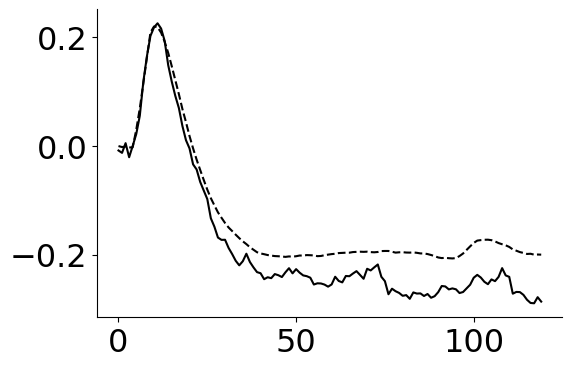

In [22]:
plt.plot(traj[0, :, 0], ls='--', c='k')
plt.plot(target[0, :, 0], c='k')

In [23]:
m1 = net2.m[:, 0].detach().numpy().squeeze()
n1 = net2.n[:, 0].detach().numpy().squeeze()
m2 = net2.m[:, 1].detach().numpy().squeeze()
n2 = net2.n[:, 1].detach().numpy().squeeze()
wi = net2.wi.detach().numpy().squeeze()
n1_p = helpers.project(n1, [m1, m2, wi])
n2_p = helpers.project(n2, [m1, m2, wi])
vecs = [m1, n1_p, m2, n2_p, wi]

J = np.outer(m1, n1) + np.outer(m2, n2)
J_o = np.outer(m1_o, n1_o) + np.outer(m2_o, n2_o)
Jf = np.outer(m1, n1_p) + np.outer(m2, n2_p)
Jf_o = np.outer(m1_o, n1_o_p) + np.outer(m2_o, n2_o_p)

# corrs['romo'] = stats.pearson_corr_list(vecs, vecs_o)
corrs['romo'] = helpers.corrvecs(Jf.ravel(), Jf_o.ravel())
print(helpers.corrvecs(J.ravel(), J_o.ravel()))
print(corrs['romo'])

0.42656505
0.9285673


# CDM

In [24]:
size = 512
noise_std = 3e-2
x_train, y_train, mask_train, x_val, y_val, mask_val = mante.generate_mante_data(1000, fraction_validation_trials=.2)
net = LowRankRNN(4, size, 1, noise_std, alpha, rank=1)
net.load_state_dict(torch.load(f'../models/mante_rank1_512.pt', map_location='cpu'))

In [25]:
m_o = net.m.detach().numpy().squeeze()
n_o = net.n.detach().numpy().squeeze()
wi1_o = net.wi[0].detach().numpy().squeeze()
wi2_o = net.wi[1].detach().numpy().squeeze()
wi_ctx1_o = net.wi[2].detach().numpy().squeeze()
wi_ctx2_o = net.wi[3].detach().numpy().squeeze()
n_o_p = helpers.project(n_o, [m_o, wi1_o, wi2_o, wi_ctx1_o, wi_ctx2_o])
vecs_o = [m_o, n_o_p, wi1_o, wi2_o, wi_ctx1_o, wi_ctx2_o]

In [26]:
net2 = LowRankRNN(4, size, size, noise_std, alpha, rank=1)
net2.load_state_dict(torch.load(f'../models/mante_fitlr_{size}.pt'))

In [27]:
r2s['mante'] = stats.r2_nets_pair(net, net2, x_val, rates=True)
m = net2.m.detach().numpy().squeeze()
n = net2.n.detach().numpy().squeeze()
wi1 = net2.wi[0].detach().numpy()
wi2 = net2.wi[1].detach().numpy()
wi_ctx1 = net2.wi[2].detach().numpy()
wi_ctx2 = net2.wi[3].detach().numpy()
n_p = helpers.project(n, [m, wi1, wi2, wi_ctx1, wi_ctx2])
vecs = [m, n_p, wi1, wi2, wi_ctx1, wi_ctx2]
# corrs['mante'] = stats.pearson_corr_list(vecs, vecs_o)


J_o = (net.m @ net.n.T).detach().numpy()
J = (net2.m @ net2.n.T).detach().numpy()
Jf_o = np.outer(m_o, n_o_p)
Jf = np.outer(m, n_p)
corrs['mante'] = helpers.corrvecs(Jf.ravel(), Jf_o.ravel())

print(r2s['mante'])
print(corrs['mante'])

0.9250452918005686
0.99072343


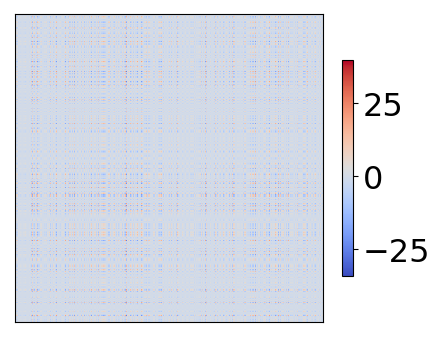

In [28]:
fig, ax = plt.subplots(figsize=(5,4))
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)
p = ax.matshow((J-J_o), cmap='coolwarm')
ax.set_xticks([])
ax.set_yticks([])
ax_cb = fig.colorbar(p, shrink=.7)
# ax_cb.set_ticks([-20, 0, 20])
plt.savefig('../figures/neurips/validation_matrix.pdf', bbox_inches='tight')

0.57232994


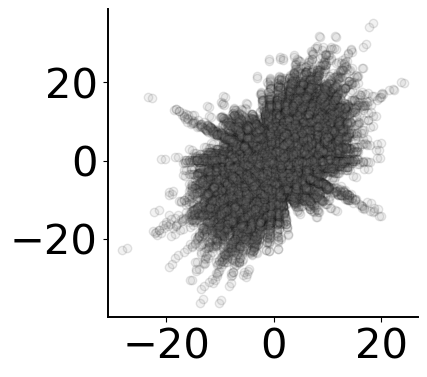

In [29]:
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['xtick.major.size'] = 3.5
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams['axes.linewidth'] = 1.4

fig, ax = plt.subplots(figsize=(4, 4))
plt.scatter(J_o, J, alpha=.1, c='gray', ec='k')

plt.xticks([-20, 0, 20])
plt.yticks([-20, 0, 20])

print(helpers.corrvecs(J_o.ravel(), J.ravel()))

plt.savefig('../figures/neurips/validation_J.png', bbox_inches='tight', dpi=300)

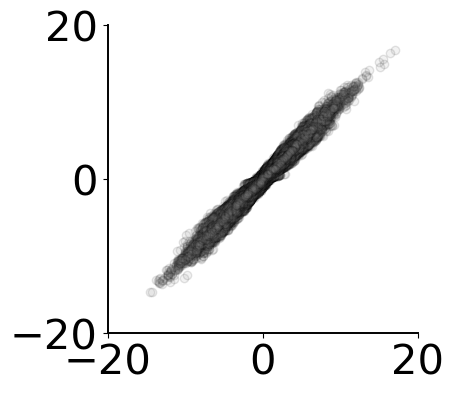

In [30]:
fig, ax = plt.subplots(figsize=(4, 4))
plt.scatter(Jf_o, Jf, alpha=.1, c='gray', ec='k')
plt.xticks([-20, 0, 20])
plt.yticks([-20, 0, 20])
plt.savefig('../figures/neurips/validation_Jf.png', bbox_inches='tight', dpi=300)

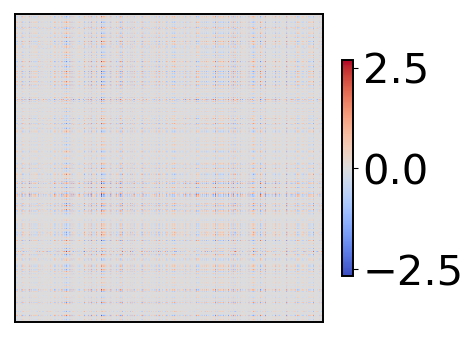

In [31]:
fig, ax = plt.subplots(figsize=(5,4))
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)
p = ax.matshow((Jf-Jf_o), cmap='coolwarm')
ax.set_xticks([])
ax.set_yticks([])
ax_cb = fig.colorbar(p, shrink=.7)
# ax_cb.set_ticks([-20, 0, 20])
# plt.savefig('../figures/neurips/validation_matrix.pdf', bbox_inches='tight')

# DMS

In [32]:
size = 512
noise_std = 5e-2
x_train, y_train, mask_train, x_val, y_val, mask_val = dms.generate_dms_data(1000)
net = LowRankRNN(2, size, 1, noise_std, alpha, rank=2)
net.load_state_dict(torch.load(f'../models/dms_rank2_{size}.pt', map_location='cpu'))
net.svd_reparametrization()
m1_o = net.m[:, 0].detach().numpy().squeeze()
m2_o = net.m[:, 1].detach().numpy().squeeze()
n1_o = net.n[:, 0].detach().numpy().squeeze()
n2_o = net.n[:, 1].detach().numpy().squeeze()
wi1_o = net.wi[0].detach().numpy().squeeze()
wi2_o = net.wi[1].detach().numpy().squeeze()

n1_o_p = helpers.project(n1_o, [m1_o, m2_o, wi1_o, wi2_o])
n2_o_p = helpers.project(n2_o, [m1_o, m2_o, wi1_o, wi2_o])
vecs_o = [m1_o, m2_o, n1_o_p, n2_o_p, wi1_o, wi2_o]

In [33]:
net2 = LowRankRNN(2, size, size, 0., alpha, rank=2)
net2.load_state_dict(torch.load(f'../models/dms_fitlr_{size}.pt'))
net2.svd_reparametrization()

In [34]:
r2s['dms'] = stats.r2_nets_pair(net, net2, x_val, rates=True)
m1 = net2.m[:, 0].detach().numpy().squeeze()
n1 = net2.n[:, 0].detach().numpy().squeeze()
m2 = net2.m[:, 1].detach().numpy().squeeze()
n2 = net2.n[:, 0].detach().numpy().squeeze()
wi1 = net2.wi[0].detach().numpy()
wi2 = net2.wi[1].detach().numpy()
n1_p = helpers.project(n1, [m1, m2, wi1, wi2])
n2_p = helpers.project(n2, [m1, m2, wi1, wi2])
vecs = [m1, m2, n1_p, n2_p, wi1, wi2]
corrs['dms'] = stats.pearson_corr_list(vecs, vecs_o)

J_o = (net.m @ net.n.T).detach().numpy()
J = (net2.m @ net2.n.T).detach().numpy()
Jf_o = np.outer(m1_o, n1_o_p) + np.outer(m2_o, n2_o_p)
Jf = np.outer(m1, n1_p) + np.outer(m2, n2_p)
corrs['dms'] = helpers.corrvecs(Jf.ravel(), Jf_o.ravel())
print(helpers.corrvecs(J_o.ravel(), J.ravel()))

print(r2s['dms'])
print(corrs['dms'])

0.39245576
0.9836763673950186
0.6280033


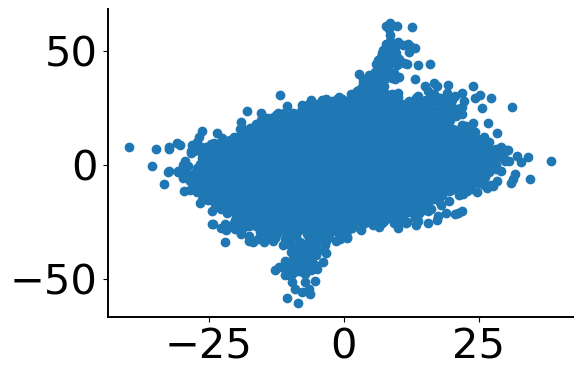

In [35]:
plt.scatter(J_o.ravel(), J.ravel())

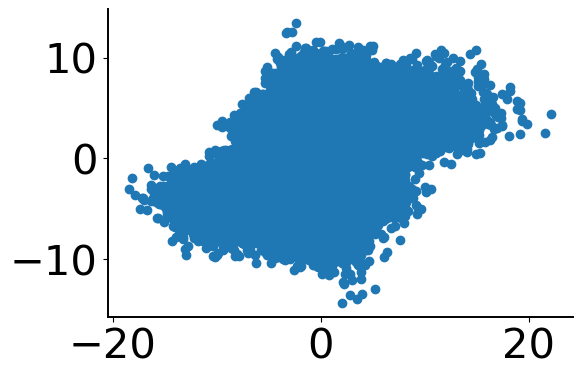

In [36]:
plt.scatter(Jf_o.ravel(), Jf.ravel())

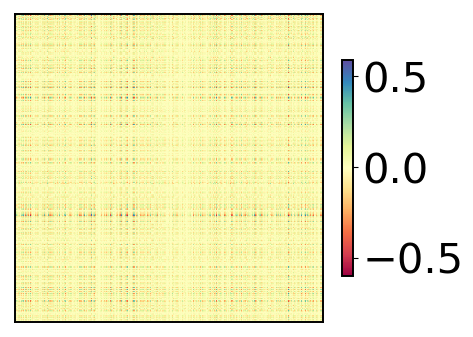

In [37]:
J_o = (net.m @ net.n.T).detach().numpy()
J = (net2.m @ net.n.T).detach().numpy()
fig, ax = plt.subplots(figsize=(5,4))
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)
p = ax.matshow((J-J_o)/np.max(np.abs(J)), cmap='Spectral')
ax.set_xticks([])
ax.set_yticks([])
ax_cb = fig.colorbar(p, shrink=.7)
# ax_cb.set_ticks([-20, 0, 20])

norm = ax_cb.norm

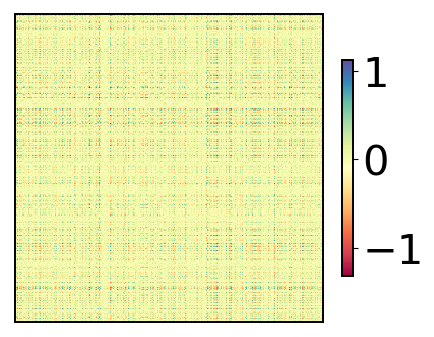

In [38]:
Jf_o = np.outer(m1_o, n1_o_p) + np.outer(m2_o, n2_o_p)
Jf = np.outer(m1, n1_p) + np.outer(m2, n2_p)

fig, ax = plt.subplots(figsize=(5,4))
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)
p = ax.matshow((Jf-Jf_o)/np.max(np.abs(Jf)), cmap='Spectral')
ax.set_xticks([])
ax.set_yticks([])
ax_cb = fig.colorbar(p, shrink=.7)
# ax_cb.set_ticks([-20, 0, 20])
# plt.savefig('../figures/neurips/validation_matrix.pdf', bbox_inches='tight')

In [39]:
corrs

{'rdm': 0.9878515, 'romo': 0.9285673, 'mante': 0.99072343, 'dms': 0.6280033}

In [40]:
print(r2s)
print(r2s.values())

{'rdm': 0.9842065934284746, 'romo': 0.9584669857108015, 'mante': 0.9250452918005686, 'dms': 0.9836763673950186}
dict_values([0.9842065934284746, 0.9584669857108015, 0.9250452918005686, 0.9836763673950186])


<BarContainer object of 4 artists>

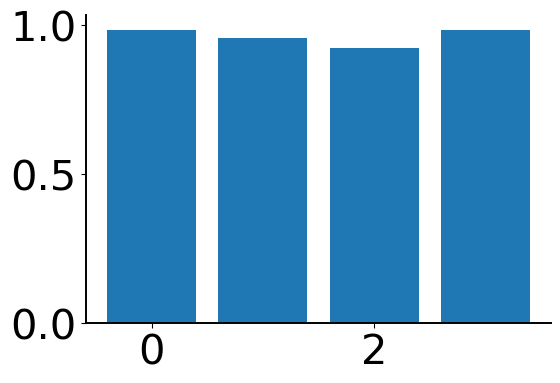

In [41]:
plt.bar([0, 1, 2, 3], list(r2s.values()))